# Project: Customer Relationship Prediction
Univ.AI <br>
AI-1 Cohort-5

## Name of the people who worked on the project:

Link to presentation: *link here*

Link to slides: *link here*

Link to poster: *link here*

Any other information:*link here*

In [5]:
# Importing required libraries and modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [6]:
# Reading train and test data
train_data = 'data/orange_small_train.data'
test_data = 'data/orange_small_test.data'
df_train = pd.read_csv(train_data, sep = '\t')
df_test = pd.read_csv(test_data, sep = '\t')
y_train = pd.read_csv('data/orange_small_train_churn.labels.txt', header= None).values

In [7]:
# Dropping columns with NaN values
df_train.dropna(axis = 1, inplace = True)

In [8]:
df_train.shape

(50000, 19)

In [9]:
y_train.shape

(50000, 1)

In [10]:
y_train = y_train.reshape(len(y_train),)
y_train.shape

(50000,)

In [11]:
# Selecting the numerical variables and categorical variables with at most 10 categories
preferred_unique_count = 10
fe_unique_columns = list(df_train.select_dtypes(include='number').columns) + list(
    (df_train.select_dtypes(include='object').nunique() < preferred_unique_count).index[
        df_train.select_dtypes(include='object').nunique() < preferred_unique_count])

In [12]:
# Performing one hot encoding
cat = ['Var196', 'Var210', 'Var211', 'Var221', 'Var227']
X_train = df_train[fe_unique_columns]
X_test = df_test[fe_unique_columns]
X_train = pd.get_dummies(X_train, cat)
X_test = pd.get_dummies(X_test, cat)

In [13]:
# Making sure that the test and train data has the same columns
X_test = X_test[X_train.columns]

In [14]:
# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.85, stratify= y_train)

In [17]:
#Setting the max_depth and n_estimators
max_depth = 20
n_estimators = 1000

## Strategy 1 - Vanilla Random Forest

- No correction for imbalance

In [18]:
# Set the maximum depth to be max_depth and use 10 estimators
vanilla_forest = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)

# Fit the model on the training set
vanilla_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=1000)

In [19]:
# Use the trained model to predict on the validation set 
predictions = vanilla_forest.predict(X_val)

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score1
f_score = f1_score(y_val, predictions)
score1 = round(f_score, 2)

# Compute the AUC and assign it to variable auc1
auc_score = roc_auc_score(y_val, predictions)
auc1 = round(auc_score, 2)

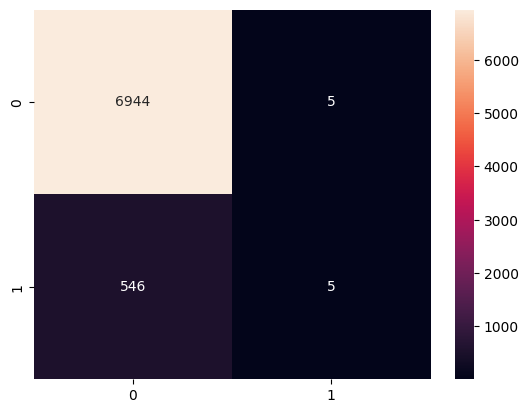

In [20]:
# Plotting confusion matrix
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot = True, fmt='d')
plt.show()

## Strategy 2 - Random Forest with class weighting
- Balancing the class imbalance in each bootstrap

In [21]:
# Use class_weight as balanced_subsample to weigh the class accordingly
rf_with_class_weights = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, class_weight = 'balanced_subsample')

# Fit the model on the training set
rf_with_class_weights.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       n_estimators=1000)

In [22]:
# Use the trained model to predict on the validation set 
predictions = rf_with_class_weights.predict(X_val)

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score2
f_score = f1_score(y_val, predictions)
score2 = round(f_score, 2)

# Compute the AUC and assign it to variable auc2
auc_score = roc_auc_score(y_val, predictions)
auc2 = round(auc_score, 2)

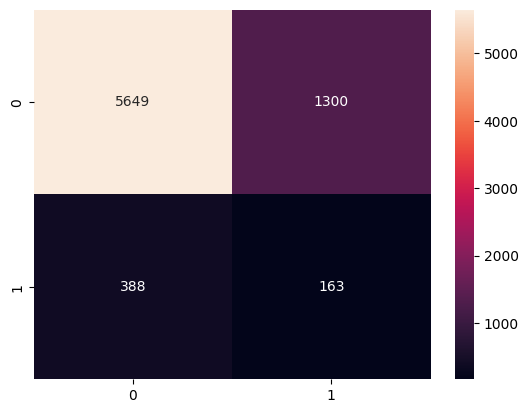

In [23]:
# Plotting confusion matrix
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot = True, fmt='d')
plt.show()

## Strategy 3 - Balanced Random Forest with SMOTE 

- Using the **imblearn** `BalancedRandomForestClassifier()` 

In [24]:
# Perform upsampling using SMOTE

# Define a SMOTE
sm = SMOTE()

# Use the SMOTE object to upsample the train data
# You may have to use ravel() 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [25]:
# Use class_weight as balanced_subsample to weigh the class accordingly
rf_smote = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, class_weight = 'balanced_subsample')

# Fit the Random Forest on upsampled data 
rf_smote.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       n_estimators=1000)

In [26]:
# Use the trained model to predict on the validation set 
predictions = rf_smote.predict(X_val)

# Compute the F1-score and assign it to variable score3
f_score = f1_score(y_val, predictions)
score3 = round(f_score, 2)

# Compute the AUC and assign it to variable auc3
auc_score = roc_auc_score(y_val, predictions)
auc3 = round(auc_score, 2)

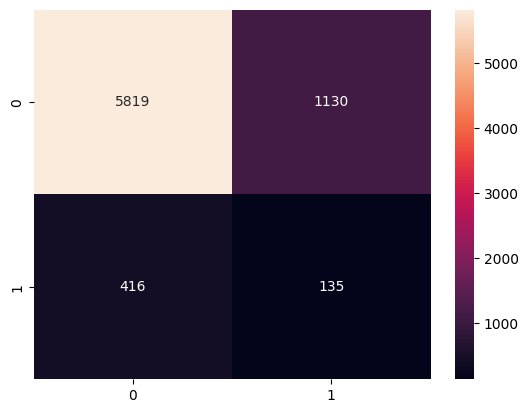

In [27]:
# Plotting confusion matrix
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot = True, fmt='d')
plt.show()

## Strategy 4 - Downsample the data

Using the imblearn RandomUnderSampler().

In [28]:
# Define an RandomUnderSampler instance
rs = RandomUnderSampler(random_state = 2)

# Downsample the train data
# You may have to use ravel()
X_train_res, y_train_res = rs.fit_resample(X_train, y_train)

In [29]:
# Use class_weight as balanced_subsample to weigh the class accordingly
rf_downsampling = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, class_weight = 'balanced_subsample')

# Fit the Random Forest on downsampled data 
rf_downsampling.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       n_estimators=1000)

In [30]:
# Use the trained model to predict on the validation set 
predictions = rf_downsampling.predict(X_val)

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score4
f_score = f1_score(y_val, predictions)
score4 = round(f_score, 2)

# Compute the AUC and assign it to variable auc4
auc_score = roc_auc_score(y_val, predictions)
auc4 = round(auc_score, 2)

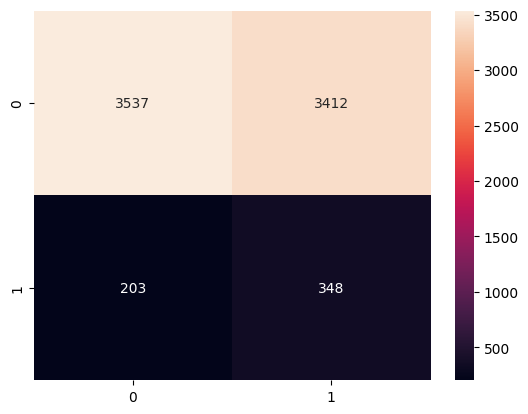

In [31]:
# Plotting confusion matrix
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot = True, fmt='d')
plt.show()

In [32]:
pt = PrettyTable()
pt.field_names = ["Strategy","F1 Score","AUC score"]
pt.add_row(["Random Forest - No imbalance correction",score1,auc1])
pt.add_row(["Random Forest - balanced_subsamples",score2,auc2])
pt.add_row(["Random Forest - Upsampling",score3,auc3])
pt.add_row(["Random Forest - Downsampling",score4,auc4])
print(pt)

+-----------------------------------------+----------+-----------+
|                 Strategy                | F1 Score | AUC score |
+-----------------------------------------+----------+-----------+
| Random Forest - No imbalance correction |   0.02   |    0.5    |
|   Random Forest - balanced_subsamples   |   0.16   |    0.55   |
|        Random Forest - Upsampling       |   0.15   |    0.54   |
|       Random Forest - Downsampling      |   0.16   |    0.57   |
+-----------------------------------------+----------+-----------+


## Plotting roc auc curve and features importance plot for Random Forest - Downsampling

In [33]:
# Function to plot an ROC curve
def plot_roc(test,logprobs,auc_score, ax):
    fpr, tpr, thresholds = roc_curve(test, logprobs)
    # plt.subplots(1, figsize=(10,10))
    # plt.title('Receiver Operating Characteristic - DecisionTree')
    # plt.plot(fpr, tpr)
    # plt.plot([0, 1], ls="--")
    # plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()
  
    plt.plot(fpr, tpr, label=f'Logistic Regression (area = {auc_score:.2f})', color = 'b')

    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', alpha=0.4)

    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    [ax.spines[key].set_visible(False) for key in ax.spines.keys() if key not in ['bottom','left']];
    ax.patch.set_facecolor('None')
    ax.patch.set_alpha(0)
    ax.legend(loc="lower right")

In [34]:
# Function to plot feature importance
# https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

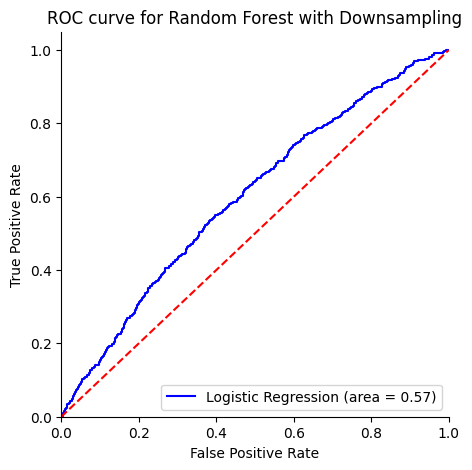

In [35]:
y_probs = rf_downsampling.predict_proba(X_val)[:,1]
fig, ax = plt.subplots(1, figsize = (5, 5))
fig.patch.set_facecolor('None')
fig.patch.set_alpha(0)
plot_roc(y_val,y_probs,auc4, ax)
plt.title('ROC curve for Random Forest with Downsampling')
plt.show()

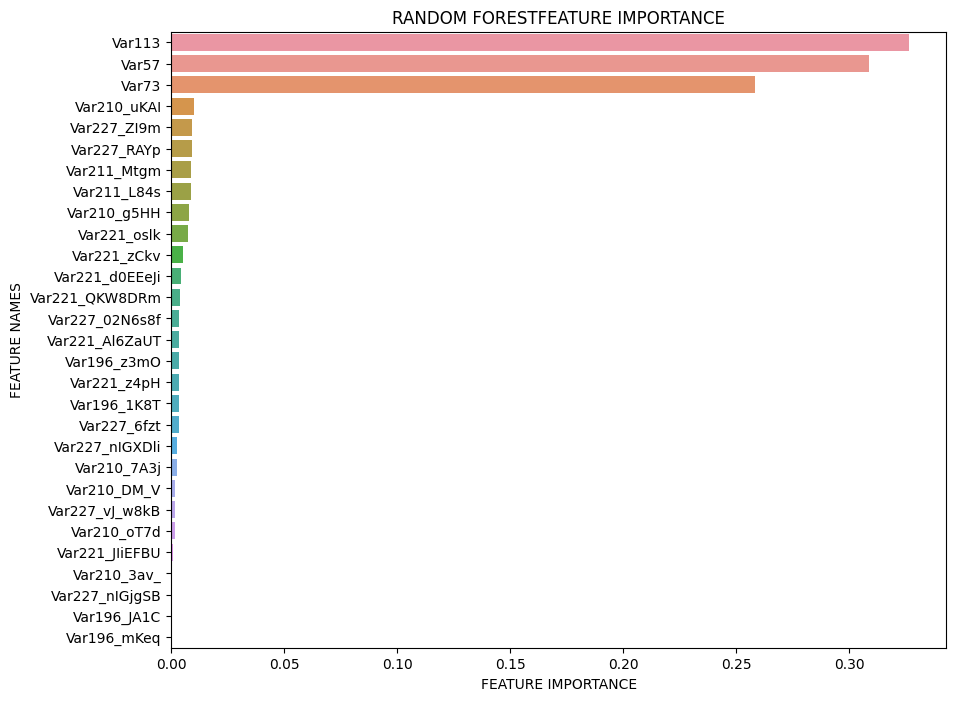

In [36]:
plot_feature_importance(rf_downsampling.feature_importances_,X_train.columns,'RANDOM FOREST')